In [1]:
import pandas
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime
import itertools
import time
import operator
%matplotlib inline

In [2]:
df = pandas.read_csv('BreadBasket_DMS.csv')
df.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


### understand the date range of the dataset

In [3]:
print(df['Date'].min())
print(df['Date'].max())

2016-10-30
2017-04-09


In [4]:
## how many days are there between the datasets first and last date
print((datetime.strptime(df['Date'].max(), '%Y-%m-%d') - datetime.strptime(df['Date'].min(), '%Y-%m-%d')).days)

## how many days are there in the dataset
df['Date'].nunique()

161


159

###  explore the items sold

In [5]:
print(df['Item'].nunique())
df.groupby('Item').size().sort_values(ascending = False).head(10)

95


Item
Coffee           5471
Bread            3325
Tea              1435
Cake             1025
Pastry            856
NONE              786
Sandwich          771
Medialuna         616
Hot chocolate     590
Cookies           540
dtype: int64

#### remove NONE item

In [6]:
print(len(df))
df = df[df['Item']!='NONE']
print(len(df))

21293
20507


## create an undirected weighted graph with all the items that appear on the same transaction

* The nodes in the graph are all the unique items that were purchased from the bakery.
* There will be an undirected edge between item x and item y if x and y appear in the same transaction.
    * Hence, a transaction that has 3 items, x,y,z, in it will produce 3 edges: (x,y), (x,z), (y,z).
* The edge between x and y will be weighted according to the number of transaction that x and y appear in together.
* If a transaction has only iteam x in it,  there will be a self edge between x and x in the graph.

In [7]:
## produce a dataframe with a list of all the unique iteams for each transaction.

item_combinations = pandas.DataFrame({'items' : df.groupby('Transaction')['Item'].unique(),
                                     'num_items' : df.groupby('Transaction')['Item'].nunique() })
item_combinations.reset_index(inplace = True)

item_combinations.head()

,Transaction,items,num_items
0,1,[Bread],1
1,2,[Scandinavian],1
2,3,"[Hot chocolate, Jam, Cookies]",3
3,4,[Muffin],1
4,5,"[Coffee, Pastry, Bread]",3


{'boxes': [<matplotlib.lines.Line2D at 0x11db0cef0>],
 'caps': [<matplotlib.lines.Line2D at 0x11db13940>,
 'fliers': [<matplotlib.lines.Line2D at 0x11db245f8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x11db241d0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x11db13080>,
  <matplotlib.lines.Line2D at 0x11db13518>]}

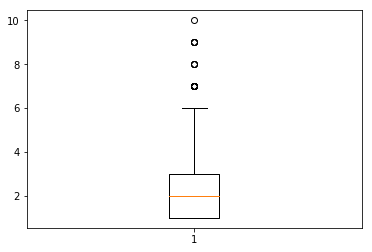

In [8]:
plt.boxplot(item_combinations['num_items'])

In [9]:
# function to take a list of items and a graph G and add all the appropriate edges to G

def add_edges_for_same_transaction(list, G):
    if len(list) == 1: ##if there is only one item in the transaction add a self-edge
        if G.has_edge(list[0], list[0]):
            G[list[0]][list[0]]['weight'] += 1 #if this edge already exists, just increase its weight by one
        else:
            G.add_edge(list[0], list[0], weight = 1) #othewise add the edge
        return G
    
    for couple in itertools.combinations(list, 2): #get all combinations of size 2 from each transaction
        if G.has_edge(couple[0], couple[1]):
            G[couple[0]][couple[1]]['weight'] += 1 
        else:
            G.add_edge(couple[0], couple[1], weight = 1) #the graph is undirected, so it doesn't matter which iteam comes first

    return G

In [10]:
# create the graph object and populate it according to item_combinations dataframe using the function above

## two ways of achieving the same thing.
## the for loop approach is much slower than the apply appraoch

start = time.time()
G = nx.Graph()
for i in range(len(item_combinations)):
    temp = item_combinations['items'][i]
    G = add_edges_for_same_transaction(temp, G)

print(G.number_of_nodes())
print(G.number_of_edges())
print(time.time() - start)

start = time.time()
G = nx.Graph()
G = item_combinations['items'].apply(lambda x: add_edges_for_same_transaction(x, G))[0]
print(G.number_of_nodes())
print(G.number_of_edges())
print(time.time() - start)

94
1112
0.2694549560546875
94
1112
0.05865001678466797


## explore the resulting graph

In [11]:
G = nx.Graph()
for i in range(len(item_combinations)):
    temp = item_combinations['items'][i]
    G = add_edges_for_same_transaction(temp, G)

print(G.number_of_nodes())
print(G.number_of_edges())

94
1112


### draw the Graph

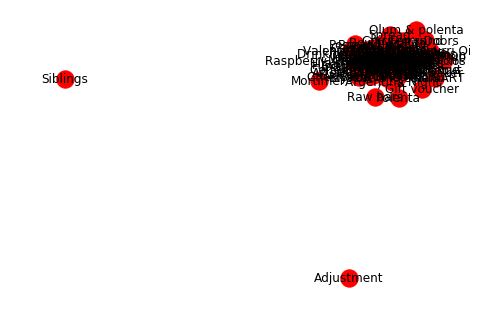

In [12]:
nx.draw(G, with_labels = True)

drawing the graph is not very helpful since everything is compressed.

### add a notion of distance to the graph

In [13]:
#this code take the weight of each edge and sets the attibute distance for that edge to be the reverse

g_distance_dict = {(e1, e2): 1 / weight for e1, e2, weight in G.edges(data='weight')}
nx.set_edge_attributes(G, g_distance_dict, 'distance')

The idea behind the above transformation is that the higher the weight between item x and y, the more frequently they appear together in transactions and hence the closer we want to consider them

### Degrees

In [184]:
#Top 10 highest degrees
sorted_degrees = sorted(dict(nx.degree(G)).items(), key=operator.itemgetter(1), reverse = True)
sorted_degrees[:10]

[('Coffee', 79),
 ('Bread', 75),
 ('Tea', 68),
 ('Cake', 64),
 ('Juice', 58),
 ('Hot chocolate', 57),
 ('Cookies', 56),
 ('Sandwich', 54),
 ('Brownie', 53),
 ('Alfajores', 52)]

In [215]:
degrees = dict(nx.degree(G, weight = 'weight'))

## the following loop is to address the fact that nx.degress doublecounts the nodes that have a self edge.
## if the node coffee has 10 edges with itself, the function will count that as 20 because. 
# So I am taking whatever the function returns and I substract once the number of selfedges, if there are any.
for key in list(degrees.keys()):
    try:
        degrees[key] = degrees[key] - G[key][key]['weight']
        #print('done')
    except: #this node doesn't have any self edges
        continue

sorted_degrees_weight = sorted(degrees.items(), key=operator.itemgetter(1), reverse = True)
sorted_degrees_weight[:10]

[('Coffee', 7285),
 ('Bread', 4722),
 ('Tea', 2572),
 ('Cake', 1997),
 ('Pastry', 1424),
 ('Sandwich', 1404),
 ('Hot chocolate', 1211),
 ('Medialuna', 1107),
 ('Cookies', 1080),
 ('Juice', 973)]

### ratio of self degreee to overall degree

What percent of the degree of each node is edges towards itself (i.e., self edges)?
The smaller the number, it means that the item is less frequently purchased by itself.

In [216]:
self_edge_ratio = dict()

for i in range(len(sorted_degrees_weight)):
    key = sorted_degrees_weight[i][0]
    try:
        self_edge_ratio[key] = G[key][key]['weight']/sorted_degrees_weight[i][1]
    except:
        self_edge_ratio[key] = 0 #this item doesnt have any edges with itself, hence no transactions that had only this item
self_edge_ratio

{'Adjustment': 1.0,
 'Afternoon with the baker': 0.5166666666666667,
 'Alfajores': 0.032133676092544985,
 'Argentina Night': 0.2727272727272727,
 'Art Tray': 0,
 'Bacon': 0,
 'Baguette': 0.29767441860465116,
 'Bakewell': 0.018518518518518517,
 'Bare Popcorn': 0.047619047619047616,
 'Basket': 0.1,
 'Bowl Nic Pitt': 0,
 'Bread': 0.2524354087251165,
 'Bread Pudding': 0,
 'Brioche and salami': 0,
 'Brownie': 0.043256997455470736,
 'Cake': 0.04957436154231347,
 'Caramel bites': 0,
 'Cherry me Dried fruit': 0,
 'Chicken Stew': 0.0636042402826855,
 'Chicken sand': 0,
 'Chimichurri Oil': 0,
 'Chocolates': 0,
 'Christmas common': 0.3333333333333333,
 'Coffee': 0.163761153054221,
 'Coffee granules ': 0.2222222222222222,
 'Coke': 0.12176165803108809,
 'Cookies': 0.041666666666666664,
 'Crepes': 0,
 'Crisps': 0.043478260869565216,
 'Drinking chocolate spoons ': 0,
 'Duck egg': 0,
 'Dulce de Leche': 0.18181818181818182,
 'Eggs': 0.11538461538461539,
 "Ella's Kitchen Pouches": 0.046511627906976744,


In [217]:
sorted_self_edge = sorted(self_edge_ratio.items(), key=operator.itemgetter(1), reverse = True)
print(sorted_self_edge[:10])
#self_edge_ratio['Coffee']

[('Siblings', 1.0),
 ('Adjustment', 1.0),
 ('Pintxos', 0.8333333333333334),
 ('Mortimer', 0.8),
 ("Valentine's card", 0.6666666666666666),
 ('Afternoon with the baker', 0.5166666666666667),
 ('Vegan Feast', 0.4166666666666667),
 ('Tshirt', 0.4),
 ('Farm House', 0.384321223709369),
 ('Christmas common', 0.3333333333333333)]

AtlasView({'Mortimer': {'weight': 4, 'distance': 0.25}, 'Coffee granules ': {'weight': 1, 'distance': 1.0}})

9

KeysView(AtlasView({'Coffee': {'weight': 1, 'distance': 1.0}, 'Juice': {'weight': 1, 'distance': 1.0}, 'Art Tray': {'weight': 1, 'distance': 1.0}}))

0
4722


79

### Explore the connectivity of the graph

In [17]:
#is the graph connected?
nx.is_connected(G)

False

### path centrality

In [18]:
## how many closests paths, is each node involved in?

nx.dijkstra_path(G, 'Coffee', 'Bread', weight = 'distance')

['Coffee', 'Bread']

In [ ]:
## what percent of purchases were the item on its own versus with other stuff